In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [60]:
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline
import torch

This notebook is a simple implementation of the inpainting process of a original size high quality mammograms.

# Inpaint healthy mammograms

We first need a listo fo all the healthy mammograms.

In [12]:
# from utils import dataset_CDD_CESM, patient_CDD

# mode = 'substracted'
# dataset_CESM = dataset_CDD_CESM(mode=mode)
# print(dataset_CESM)

# # find normal cases
# normal_cases_meta = dataset_CESM.metadata[dataset_CESM.metadata['Tags']=='normal'].reset_index(drop=True)
# # save 
# normal_cases_meta.to_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv', index=False)

Check visually the normal cases, and their closeups

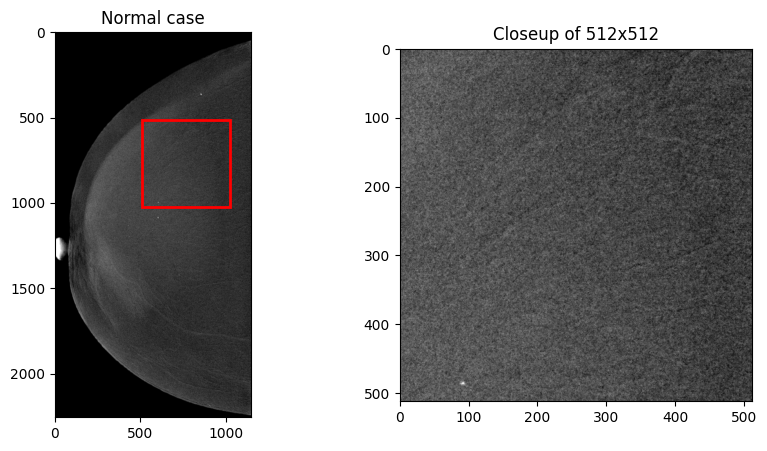

In [3]:
# data
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
normal_cases_meta = pd.read_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv')

# row_example
row = normal_cases_meta.iloc[2]

# load the image
im_path = im_dir / (row['Image_name'] + '.jpg')
im_path = im_path.with_name(im_path.name.replace(' ', '')) # rmeove space if necessary
im = cv.imread(str(im_path), cv.IMREAD_GRAYSCALE)

# closeup
x1, y1, x2, y2 = 512, 512, 1024, 1024

# show image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Normal case')
# closup of 512x512
im_closup = im[y1:y2, x1:x2]
axs[1].imshow(im_closup, cmap='gray')
axs[1].set_title('Closeup of 512x512')
# show bbox of closeup in original image
axs[0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', lw=2))

plt.show()

In [57]:
def compute_area_stas():

    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_areas = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512: # excluding large cases
            # compute mask area
            mask_areas.append(bbox[2]*bbox[3])


    # get 25th and 75th percentiles
    q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)

    return q25, q75

def compute_ratios():
    
    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_ratios = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512:
            # compute mask area
            mask_ratios.append(bbox[3]/bbox[2])
    
    # compute mean and std
    mean, std = np.mean(mask_ratios), np.std(mask_ratios)

    return mean, std

def create_bbox(im_xrange, im_yrange, area_range, ratio_range):
    while True:
        # sample x and y
        x1 = np.random.randint(im_xrange[0], im_xrange[1])
        y1 = np.random.randint(im_yrange[0], im_yrange[1])
        # sample area and ratio
        area = np.random.randint(area_range[0], area_range[1])
        ratio = np.random.uniform(ratio_range[0], ratio_range[1])

        # compute width and height
        width = int(np.sqrt(area*ratio))
        height = int(np.sqrt(area/ratio))

        # compute other corners
        x2 = x1 + width
        y2 = y1 + height

        # if all corners are inside the mask
        if x2 < im_xrange[1] and y2 < im_yrange[1]:
            # create mask of the bbox
            bbox_mask = np.zeros((im_xrange[1], im_yrange[1]), dtype=np.uint8)
            bbox_mask[y1:y2,x1:x2] = 255

            break
    
    return bbox_mask, (x1, y1, x2, y2)

25th percentile: 19832.0, 75th percentile: 98427.0
ratio mean: 1.0027800839513035, ratio std: 0.4185633550698671


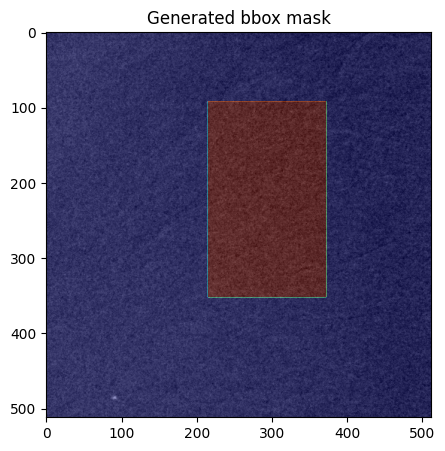

In [56]:
# compute area stats
q25, q75 = compute_area_stas()
print(f'25th percentile: {q25}, 75th percentile: {q75}')
mean, std = compute_ratios()
print(f'ratio mean: {mean}, ratio std: {std}')
# define ranges
area_range = (q25, q75)
ratio_range = (mean - std, mean + std)
im_xrange = (0, 512)
im_yrange = (0, 512)

# create bbox
bbox_mask, bbox = create_bbox(im_xrange, im_yrange, area_range, ratio_range)

plt.figure(figsize=(5,5))
plt.imshow(im_closup, cmap='gray')
plt.title('Generated bbox mask')
plt.imshow(bbox_mask, cmap='jet', alpha=0.4)
plt.show()

# Inpaiting process

In [58]:
# define model and load weights
model_dir=repo_path / 'generation/inpainting/results/CEM-small_mass_split-1'
pipe = DiffusionPipeline.from_pretrained(
    model_dir,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [61]:
# Set diffusion pipeline
im_RGB = Image.fromarray(im_closup)
prompt = "a mammogram with a lesion"
negative_prompt = ""
num_samples = 1

 # HP
diffusion_steps = 40
guidance_scale = 4

with torch.autocast("cuda"), torch.inference_mode():
    synth = pipe(
        prompt=prompt,
        image=im_RGB,
        mask_image=bbox_mask, # mask coming from the sketchpad
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=diffusion_steps,
        guidance_scale=guidance_scale,
        height=512,
        width=512,
        generator=None,
    ).images[0]

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`